# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [ ]:
# Mounting Google Drive:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Create Pickle file

In [ ]:
# import pickle
# import os

# # Path to the file
# file_path = '/content/Copy_of_prompt_III_ComparingClassifiers.pkl'

# # Verify the file path
# absolute_path = os.path.abspath(file_path)
# print(f'Absolute file path: {absolute_path}')

# # Load the pickle file
# with open(file_path, 'rb') as file:
#     loaded_data = pickle.load(file)

# # Use the 'loaded_data' variable as needed
# print(loaded_data)

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import time

import random

import warnings
warnings.filterwarnings('ignore')

In [32]:
random.seed(1)

Install the ucimlrepo package

In [33]:
pip install ucimlrepo

Import Dataset from UCI Machine Learning Repository

In [34]:
#df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')

from ucimlrepo import fetch_ucirepo

# fetch dataset
df = fetch_ucirepo(id=222)


# metadata
print(df.metadata)

# variable information
print(df.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

In [35]:
# Extract features and targets from the dotdict
X = df.data.features
y = df.data.targets

# Create a DataFrame from the features
df_bank = pd.DataFrame(X)

# add the target as a column
df_bank['Target'] = y

df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Identifying the missing values from the features

In [36]:
df_bank.isnull().sum()


,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


---
1. Excluded "poutcome" feature as it is missing majority of the data (~82%)

2. Excluded "duration" feature, as it has variances in the data and this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known.
Thus, this attributes should be discarded if the intention is to have a realistic predictive model.

3. Excluded "balance" feature, description is not available in the data description file, and no clarity on the values of the feature, hence excluded the feature

4. Update the missing values in the features "job","education", and "contact" with the value 'unknown'

In [37]:
df_bank = df_bank.drop(['poutcome', 'duration', 'balance'], axis=1).fillna('unknown')

In [38]:
df_bank.describe()

,age,day_of_week,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,2.763841,40.197828,0.580323
std,10.618762,8.322476,3.098021,100.128746,2.303441
min,18.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,31.000000,63.000000,871.000000,275.000000


Categorizing Age Data Using apply with a Custom Function

In [39]:
print (df_bank['age'].unique())

[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]


In [40]:
# Define the custom function to categorize age
def categorize_age(age):
    if age < 25:
        return '25 or below'
    elif age < 50:
        return '25-50'
    elif age < 75:
        return '50-75'
    else:
        return 'above 75'

# Apply the custom function to the 'age' column
df_bank['age'] = df_bank['age'].apply(categorize_age)

# check the categories of age
print(df_bank['age'].unique())

['50-75' '25-50' '25 or below' 'above 75']


Verify unique values in the 'education' attribue

In [41]:
df_bank['education'].unique ()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [ ]:
# Define the function to categorize education levels
# def categorize_education(education):
#     if education in ['illiterate', 'basic.4y', 'basic.6y']:
#         return 'Low'
#     elif education in ['basic.9y', 'high.school']:
#         return 'Medium'
#     elif education in ['professional.course', 'university.degree']:
#         return 'High'
#     else:  # For 'unknown'
#         return 'unknown'

# # Apply the function to the DataFrame
# df_bank['education'] = df_bank['education'].apply(categorize_education)

# # Check the unique values in the 'education' column
# print(df_bank['education'].unique())

In [42]:
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,day_of_week,month,campaign,pdays,previous,Target
0,50-75,management,married,tertiary,no,yes,no,unknown,5,may,1,-1,0,no
1,25-50,technician,single,secondary,no,yes,no,unknown,5,may,1,-1,0,no
2,25-50,entrepreneur,married,secondary,no,yes,yes,unknown,5,may,1,-1,0,no
3,25-50,blue-collar,married,unknown,no,yes,no,unknown,5,may,1,-1,0,no
4,25-50,unknown,single,unknown,no,no,no,unknown,5,may,1,-1,0,no


Plotting the histogram for Client subscribed a term deposit.

Plot indicates that the data is imbalanced

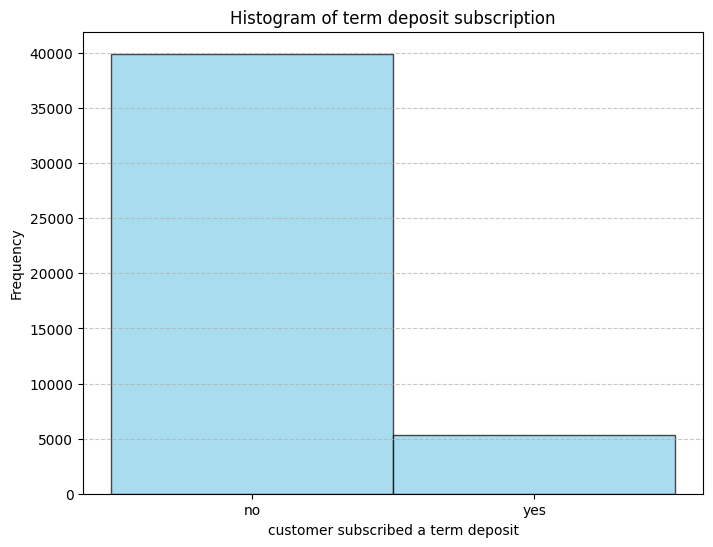

In [43]:
plt.figure(figsize=(8, 6))
plt.hist(df_bank['Target'], bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('customer subscribed a term deposit')
plt.ylabel('Frequency')
plt.title('Histogram of term deposit subscription')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

***Business Objective*** :
*Goal of this task is to predict if the client will subscribe a term deposit (yes/no)*

*This is binary classification issue with the imbalanced data*

In [45]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  object
 1   job          45211 non-null  object
 2   marital      45211 non-null  object
 3   education    45211 non-null  object
 4   default      45211 non-null  object
 5   housing      45211 non-null  object
 6   loan         45211 non-null  object
 7   contact      45211 non-null  object
 8   day_of_week  45211 non-null  int64 
 9   month        45211 non-null  object
 10  campaign     45211 non-null  int64 
 11  pdays        45211 non-null  int64 
 12  previous     45211 non-null  int64 
 13  Target       45211 non-null  object
dtypes: int64(4), object(10)
memory usage: 4.8+ MB


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

 prepare the features and target column

In [46]:
X = df_bank.drop(['Target'],axis=1)
y = df_bank['Target']

print(X.shape)
print(y.shape)

(45211, 13)
(45211,)


encoding and transformations of the features

In [47]:
selector =''
selector = make_column_selector(dtype_include=object)

transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), selector),
    remainder=StandardScaler()
)


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=518, stratify=y)

Fit and Transform the data

In [49]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Establishing a baseline performance is a crucial step in evaluating a machine learning model. The baseline provides a reference point against which you can measure the performance of your classifier.

Determine the baseline metric using ***Simple Majority Class*** and ***Random Guessing Baseline*** approaches.

***Simple Majority Class :***
If the dataset is imbalanced, a common baseline is the performance of a classifier that always predicts the majority class.

This is useful for imbalanced datasets. If your classifier cannot outperform this baseline, it indicates that the model is not learning useful patterns.

***Random Guessing Baseline :***
Random Guessing baseline is the performance of a classifier that makes random guesses based on class distribution.

This helps in understanding whether your model is making predictions better than random chance.

---
establish the baseline performance using one of these methods and use it as a benchmark for evaluating the effectiveness of your machine learning model.




In [50]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create and train a DummyClassifier with 'most_frequent' strategy
dummy_clf_majority = DummyClassifier(strategy='most_frequent', random_state=518)
dummy_clf_majority.fit(X_train, y_train)
y_pred_majority = dummy_clf_majority.predict(X_test)
baseline_accuracy_majority = accuracy_score(y_test, y_pred_majority)
print(f'Baseline Accuracy (Majority Class): {baseline_accuracy_majority:.4f}')

# Create and train a DummyClassifier with 'stratified' strategy
dummy_clf_random = DummyClassifier(strategy='stratified', random_state=518)
dummy_clf_random.fit(X_train, y_train)
y_pred_random = dummy_clf_random.predict(X_test)
baseline_accuracy_random = accuracy_score(y_test, y_pred_random)
print(f'Baseline Accuracy (Random Guessing): {baseline_accuracy_random:.4f}')

Baseline Accuracy (Majority Class): 0.8830
Baseline Accuracy (Random Guessing): 0.7929


**Observations :** \
Baseline Accuracy (Majority Class): 0.8830 (88.30%) \
Baseline Accuracy (Random Guessing): 0.7929 (79.29%) \
Simple Majority CLass delivered higher accuracy thand Random Guessing

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

*Initialize and Train the model*

In [51]:
lreg = LogisticRegression(random_state=518)
lreg.fit(X_train, y_train)

LogisticRegression(random_state=518)

*Predict on Test data*

In [52]:
y_pred = lreg.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [53]:
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8847
Classification Report:
              precision    recall  f1-score   support

          no       0.89      0.99      0.94      9981
         yes       0.54      0.09      0.16      1322

    accuracy                           0.88     11303
   macro avg       0.72      0.54      0.55     11303
weighted avg       0.85      0.88      0.85     11303

Confusion Matrix:
[[9879  102]
 [1201  121]]


Accuracy of the Simple Model (Logistic Regression) is 0.88 (88%)

*Plotting Confusion Matrix*

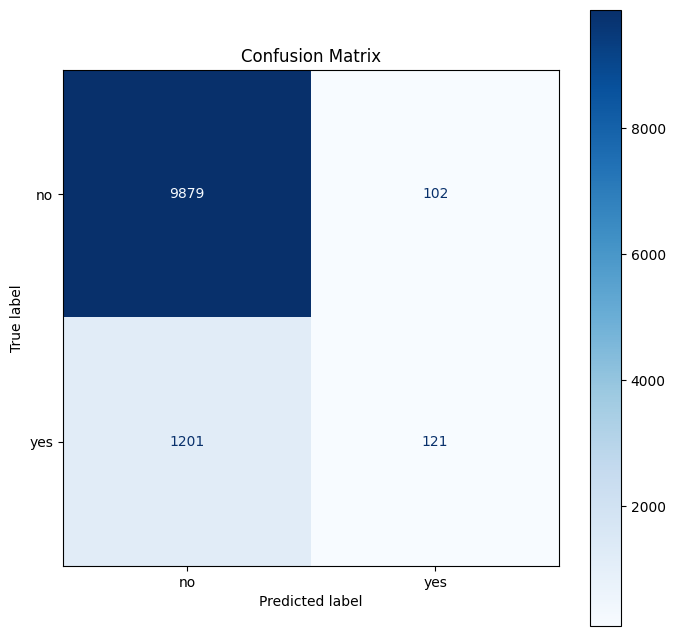

In [54]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lreg.classes_)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title('Confusion Matrix')
plt.show()


---
**Observations:**
*Accuracy of Logistic Regression model is 88%, it indicates that this model is performing same as the baseline model* \

True Negatives (TN): 9879 \
The number of times the model correctly predicted the negative class (0) as negative. \
False Positives (FP): 102 \
The number of times the model incorrectly predicted the positive class (1) as negative. \
False Negatives (FN): 1201 \
The number of times the model incorrectly predicted the negative class (0) as positive. \
True Positives (TP): 121 \
The number of times the model correctly predicted the positive class (1) as positive. \

True Negatives (TN): 9879 - Correctly predicted class 0. \
False Positives (FP): 102 - Incorrectly predicted class 1 as class 0. \
False Negatives (FN): 1201 - Incorrectly predicted class 0 as class 1. \
True Positives (TP): 121 - Correctly predicted class 1. \

The matrix and derived metrics indicate that the model is more effective at predicting class 0 than class 1, given the higher number of true negatives and lower true positives. \
The low recall for class 1 suggests that the model misses many of the positive cases, which might be crucial depending on the problem context.



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

*Define parameter grids for each model with defualt settings*

In [108]:
param_grids = {
    'Logistic Regression': {
               'C': [1.0],                       # Regularization strength (default is 1.0)
               'penalty': ['l2'],                # Type of regularization (default is 'l2')
               'solver': ['lbfgs']               # Optimization algorithm (default is 'lbfgs')
    },
    'Decision Tree': {
              'criterion': ['gini'],            # Function to measure the quality of a split (default is 'gini')
              'max_depth': [None],              # Maximum depth of the tree (default is None)
              'min_samples_split': [2],         # Minimum number of samples required to split an internal node (default is 2)
              'min_samples_leaf': [1],          # Minimum number of samples required to be at a leaf node (default is 1)
              'max_features': [None]            # Number of features to consider when looking for the best split (default is None)
    },
    'KNN': {
              'n_neighbors': [5],               # Number of neighbors to use (default is 5)
              'weights': ['uniform'],           # Weight function used in prediction (default is 'uniform')
              'p': [2]                          # Power parameter for the Minkowski metric (default is 2)
    },
    'SVM': {
              'C': [1.0],                       # Regularization parameter (default is 1.0)
              'kernel': ['rbf'],                # Type of kernel (default is 'rbf')
              'degree': [3],                    # Degree of the polynomial kernel function (default is 3, used only if kernel='poly')
              'gamma': ['scale']                # Kernel coefficient (default is 'scale')
    }
}



*Initialize models*

In [109]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True)
}

*Function to evaluate models*

In [110]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

    start_time = time.time()  # To estimate Search Time

    # Fit the model
    model.fit(X_train, y_train)

    end_time = time.time()
    train_time = end_time - start_time

    # Predict on the test set
    y_pred = model.predict(X_test)
  #  y_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

    # Convert categorical labels to numeric if needed (e.g., {'no': 0, 'yes': 1})
  #  pos_label = 'yes'  # Replace 'yes' with the actual positive class label

    # Calculate performance metrics
    train_accuracy = accuracy_score(y_train, model.predict(X_train))  # Accuracy on training data
    test_accuracy = accuracy_score(y_test, y_pred)  # Accuracy on test data
   # precision = precision_score(y_test, y_pred)
   # recall = recall_score(y_test, y_pred)
   # f1 = f1_score(y_test, y_pred)
   # roc_auc = roc_auc_score(y_test, y_proba)

    return {
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
       # 'Precision': precision,
       # 'Recall': recall,
       # 'F1 Score': f1,
      #  'ROC AUC': roc_auc
    }

In [111]:
# Evaluate each model
results = {}
for model_name, model in models.items():
    results[model_name] = evaluate_model(model, X_train, X_test, y_train, y_test)

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                     Train Time  Train Accuracy  Test Accuracy
Logistic Regression    0.218932        0.883479       0.884721
Decision Tree          1.055883        0.982010       0.841546
KNN                    0.039255        0.904595       0.878439
SVM                  330.471341        0.894332       0.885606


In [112]:
results_df.index.name = 'Model'
results_df.reset_index(inplace=True)

results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.218932,0.883479,0.884721
1,Decision Tree,1.055883,0.982010,0.841546
2,KNN,0.039255,0.904595,0.878439
3,SVM,330.471341,0.894332,0.885606


*Plotting performance metrics of the models*\


Multiple Subpllots

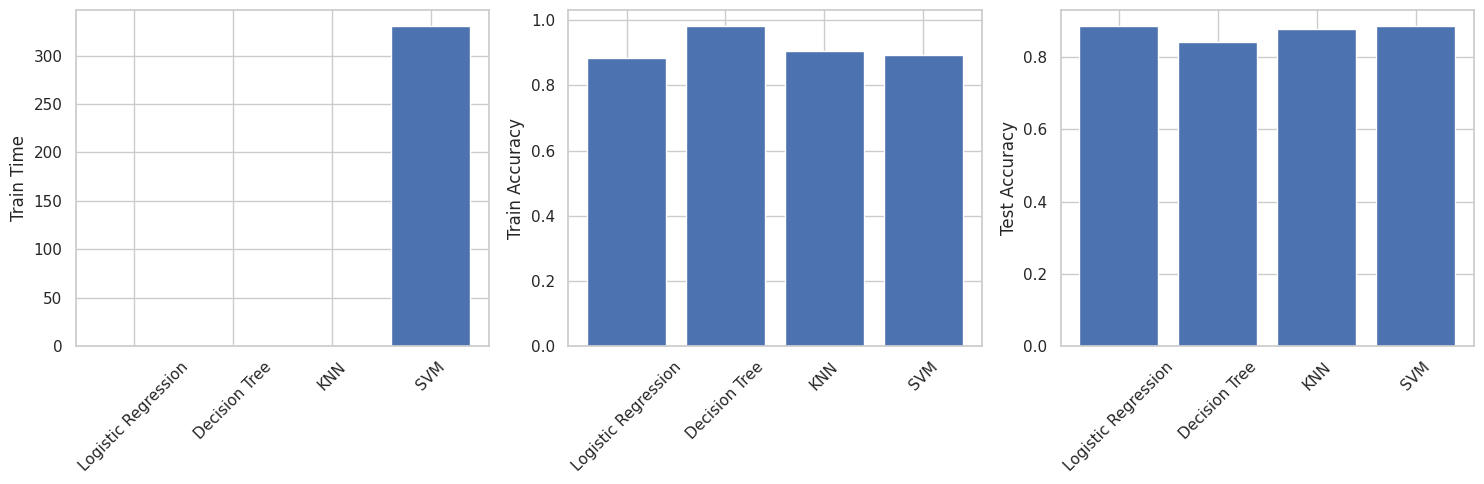

In [114]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(df['Model'], df['Train Time'])
axes[0].set_ylabel('Train Time')
axes[0].set_xticklabels(df['Model'], rotation=45)

axes[1].bar(df['Model'], df['Train Accuracy'])
axes[1].set_ylabel('Train Accuracy')
axes[1].set_xticklabels(df['Model'], rotation=45)

axes[2].bar(df['Model'], df['Test Accuracy'])
axes[2].set_ylabel('Test Accuracy')
axes[2].set_xticklabels(df['Model'], rotation=45)

plt.tight_layout()
plt.show()

Lineplot to visualize the each model metrics

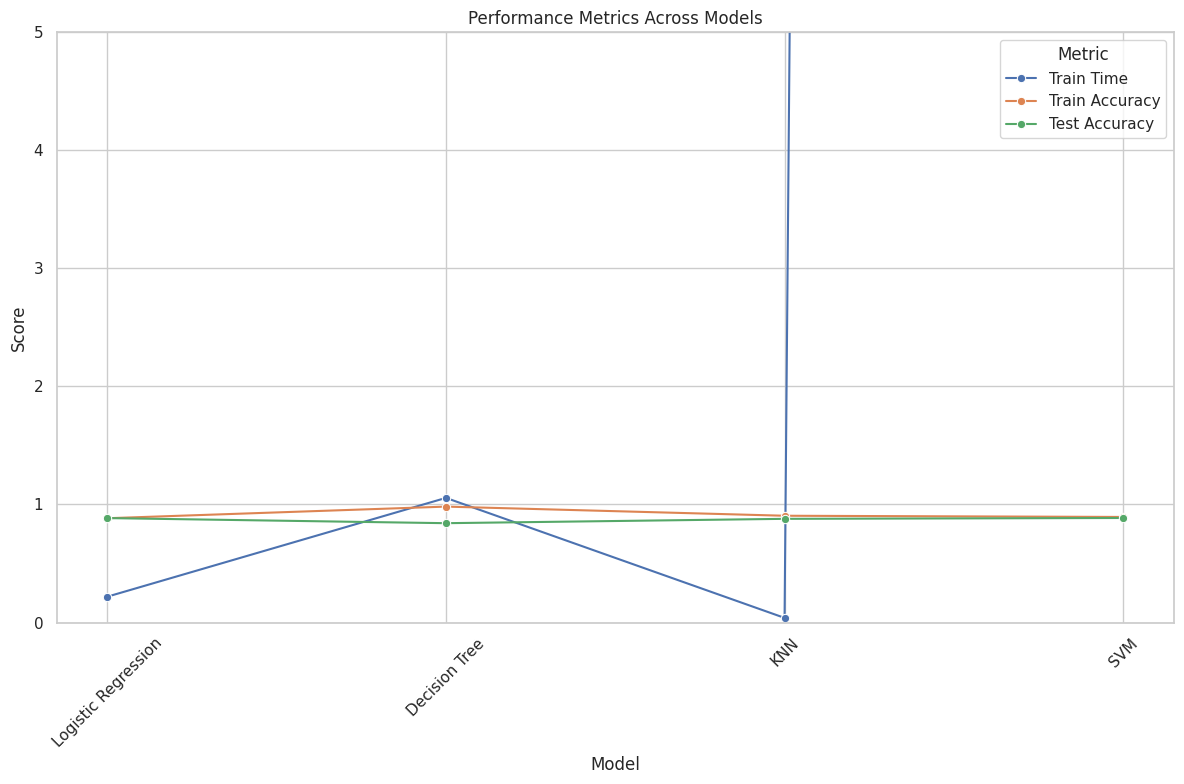

In [115]:
#df = pd.DataFrame(results_df)

# Set the plot style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for seaborn
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_melted, x='Model', y='Score', hue='Metric', marker='o')

# Rotate x labels for better readability
plt.xticks(rotation=45)

# Set plot labels and title
plt.title('Performance Metrics Across Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 5)  # Set y-axis limits for better comparison

# Display the plot
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


**Explanation of Each Model's Metrics**

The metrics provided pertain to the performance of different machine learning models. They include:

***Train Time:*** The amount of time it takes to train the model. \
***Train Accuracy:*** The accuracy of the model on the training dataset.\
***Test Accuracy:*** The accuracy of the model on the test dataset.\

***explanation of each metric for the models listed:***

**1. Logistic Regression**

***Train Time:*** 0.218932 seconds\
Logistic Regression is a relatively simple algorithm and generally requires less time to train compared to more complex models. In this case, it took approximately 0.22 seconds. \

***Train Accuracy: *** 0.883479 (88.34%) \
This is the accuracy of the model on the training data, meaning it correctly predicted the target variable approximately 88.35% of the time on the data it was trained on. \

***Test Accuracy:*** 0.884721 (88.47%)\
This is the accuracy of the model on the test data, meaning it correctly predicted the target variable approximately 88.47% of the time on unseen data. The test accuracy is slightly higher than the training accuracy, which is often a good sign indicating that the model generalizes well. \

**2. Decision Tree**

***Train Time:*** 1.053792 seconds \
Decision Trees tend to be more complex and can take more time to train, especially if the tree depth is significant. In this case, it took approximately 1.05 seconds. \

***Train Accuracy:*** 0.982010 (98.20%)
This high accuracy on the training set indicates that the model fits the training data very well. However, a very high training accuracy can sometimes indicate overfitting, especially if the test accuracy is significantly lower. \

***Test Accuracy:*** 0.841546 (84.15%) \
The model's performance on the test set is lower compared to the training set. This drop in accuracy suggests that the Decision Tree might be overfitting the training data and may not generalize as well to unseen data. \

**3. KNN (k-Nearest Neighbors)**

***Train Time:*** 0.039255 seconds \
KNN is generally quick to train as it does not build a model per se but rather stores the training data. However, prediction time can be longer as it involves searching through the dataset to find the nearest neighbors.\

***Train Accuracy:*** 0.904595 (90.46%)\
KNN has a good accuracy on the training set, indicating that it performs well on the data it was trained on.\

***Test Accuracy:*** 0.878439 (87.84%)\
The test accuracy is slightly lower than the training accuracy. This is expected as the model's performance on new, unseen data can be lower than on the data it has seen. However, the drop is not as severe as seen with the Decision Tree.\

**4. SVM (Support Vector Machine)**\

***Train Time:*** 330.471341 seconds (approximately 5.50 minutes)\
SVMs can be computationally intensive, especially with large datasets or non-linear kernels. The training time here is significantly higher than the other models, reflecting the complexity and computation involved in training an SVM.\

***Train Accuracy:*** 0.894332 (89.43%)\
The SVM model performs well on the training data, but not as well as the Decision Tree. The training accuracy suggests that the model fits the training data relatively well.\

***Test Accuracy:*** 0.885606 (88.56%)\
The test accuracy is very close to the training accuracy, which indicates that the SVM model generalizes well to new, unseen data. The small drop in accuracy compared to the training data is expected.\

***Summary of Metrics***\

***Train Time:*** Indicates the computational cost of training each model. SVM has the highest train time, suggesting it's the most computationally demanding.\

***Train Accuracy:*** Shows how well the model performs on the training dataset. Higher train accuracy can indicate better model performance but might also suggest overfitting if it is too high compared to test accuracy.\

***Test Accuracy:*** Reflects the model's ability to generalize to new, unseen data. It’s an important metric to evaluate how well the model performs in real-world scenarios.\

In summary, you should balance between train time, train accuracy, and test accuracy depending on your specific use case. A model with high train accuracy but low test accuracy might be overfitting, while a model with similar train and test accuracy suggests good generalization.

**Create pickle file to submit**

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [86]:
# Define parameter grids for each model
# SVM model has been excluded due computational resources issues
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'param_grid': {
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
        }
    }
    # 'SVM': {   # excluded due to computational resource contraints
    #     'model': SVC(),
    #     'param_grid': {
    #         'C': [0.1, 1, 10, 100],
    #         'kernel': ['linear', 'rbf'],
    #         'gamma': ['scale', 'auto']
    #     }
    }



In [87]:
# Run GridSearch - Create a function to run grid search for each model and print results.

def run_grid_search(model_name, model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
   # grid_search.fit(X_train, y_train)

    start_time1 = time.time()  # To estimate Search Time
    # Fit the model
    grid_search.fit(X_train, y_train)

    end_time1 = time.time()
    train_time1 = end_time1 - start_time1

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    return {
        'model': model_name,
        'best_params': best_params,
        'best_train_accuracy': best_score,
        'test_accuracy': test_accuracy,
        'Train Time': train_time1
    }

results = []
for model_name, grid_info in param_grids.items():
    result = run_grid_search(model_name, grid_info['model'], grid_info['param_grid'])
    results.append(result)

# Convert results to DataFrame for better readability
import pandas as pd
results_df1 = pd.DataFrame(results)
print(results_df1)




                 model                                        best_params  \
0  Logistic Regression  {'C': 0.1, 'penalty': 'l1', 'solver': 'libline...   
1        Decision Tree  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
2                  KNN  {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}   

   best_train_accuracy  test_accuracy  Train Time  
0             0.883449       0.884632    4.029953  
1             0.886045       0.884544   10.020406  
2             0.885455       0.885517  303.149477  


In [88]:
# Find the best model based on test accuracy
best_model_row = results_df1.loc[results_df1['test_accuracy'].idxmax()]

print("Best Model:")
print(f"Model: {best_model_row['model']}")
print(f"Best Parameters: {best_model_row['best_params']}")
print(f"Best Train Accuracy: {best_model_row['best_train_accuracy']:.3f}")
print(f"Test Accuracy: {best_model_row['test_accuracy']:.3f}")

Best Model:
Model: KNN
Best Parameters: {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
Best Train Accuracy: 0.885
Test Accuracy: 0.886


**Visualization**
The most effective way to visualize this data would be to use a combination of bar plots and scatter plots to compare the models across different metrics.

In [95]:

results_df1 = results_df1.drop(['best_params'],axis=1)
print(results_df1)


                 model  best_train_accuracy  test_accuracy  Train Time
0  Logistic Regression             0.883449       0.884632    4.029953
1        Decision Tree             0.886045       0.884544   10.020406
2                  KNN             0.885455       0.885517  303.149477


In [96]:
results_df1.rename(columns={'best_train_accuracy': 'train_accuracy'}, inplace=True)
print(results_df1)

                 model  train_accuracy  test_accuracy  Train Time
0  Logistic Regression        0.883449       0.884632    4.029953
1        Decision Tree        0.886045       0.884544   10.020406
2                  KNN        0.885455       0.885517  303.149477


<Axes: ylabel='Train Time'>

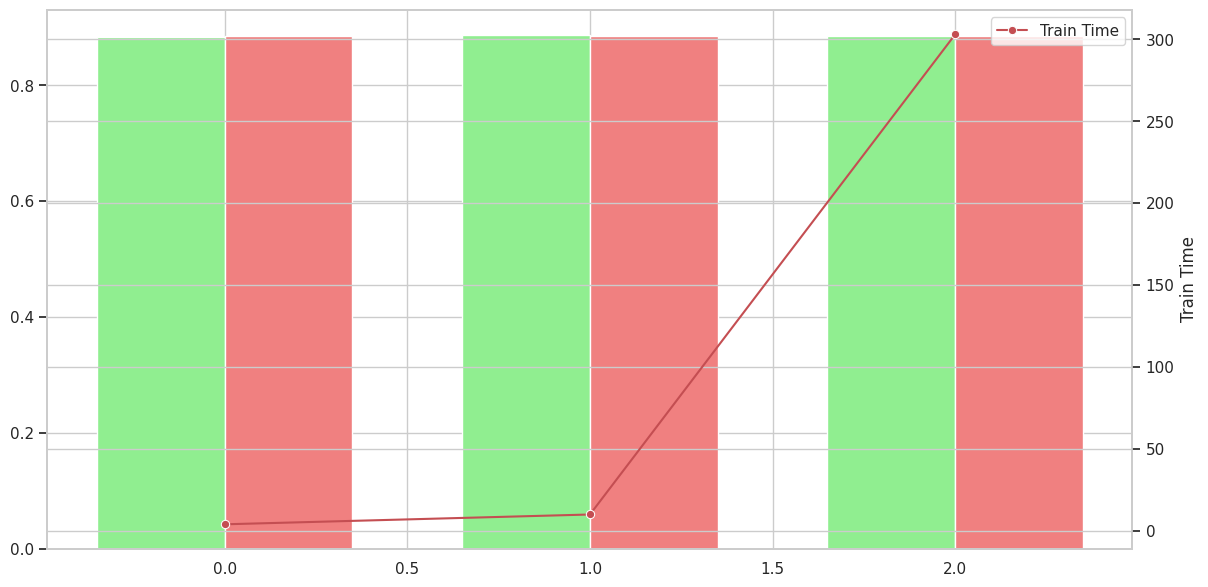

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Set up the aesthetics for the plots
index = np.arange(len(results_df1))
bar_width = 0.35  # Adjusted width to fit both bars side by side

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot train and test accuracy as bars
bars1 = ax1.bar(index - bar_width/2, results_df1['train_accuracy'], bar_width, label='Train Accuracy', color='lightgreen')
bars2 = ax1.bar(index + bar_width/2, results_df1['test_accuracy'], bar_width, label='Test Accuracy', color='lightcoral')

# Create a secondary y-axis for train time
ax2 = ax1.twinx()
sns.lineplot(x=index, y=results_df1['Train Time'], color='r', marker='o', label='Train Time', ax=ax2)

# Add titles


**Interpretation of the Performance Metrics**

***1. Logistic Regression*** \
Train Accuracy: 0.883 (88.3%) \
Test Accuracy: 0.885 (88.5%) \
Train Time: 4.03 seconds \

**Interpretation:**\
***Train Accuracy vs. Test Accuracy:*** The Logistic Regression model has very similar train and test accuracies, indicating that it generalizes well and does not overfit the training data. \
***Train Time:*** The training time is relatively short, making it efficient. This is expected as Logistic Regression is generally computationally less intensive compared to other models. \
***Overall Performance:*** This model is quite efficient and performs consistently across both training and test datasets, with a minimal training time. It is a good choice if you need a balance of accuracy and efficiency. \

***2. Decision Tree*** \
Train Accuracy: 0.886 (88.6%) \
Test Accuracy: 0.885 (88.5%) \
Train Time: 10.02 seconds \

**Interpretation:** \
***Train Accuracy vs. Test Accuracy:*** The Decision Tree model also shows similar train and test accuracies, which suggests good generalization. The test accuracy is slightly lower than the train accuracy, but the difference is minor. \
***Train Time:*** The training time is longer than that of Logistic Regression but still relatively short compared to KNN. Decision Trees generally take longer to train than simpler models, but 10 seconds is manageable. \
***Overall Performance: ***This model performs similarly to Logistic Regression in terms of accuracy but takes a bit longer to train. It provides slightly higher train accuracy, which might suggest a better fit on the training data. \

***3. KNN (K-Nearest Neighbors)*** \

***Train Accuracy:*** 0.885 (88.5%) \
***Test Accuracy:*** 0.886 (88.6%) \
***Train Time:*** 303.15 seconds \

Interpretation: ***bold text*** \
***Train Accuracy vs. Test Accuracy:*** The KNN model has very similar train and test accuracies, with a slight edge in test accuracy. This indicates good generalization with a minor improvement on unseen data. \
***Train Time:*** The training time is significantly longer than both Logistic Regression and Decision Tree models. KNN’s training time can be high because it involves storing the entire training dataset and using it for making predictions. This time could increase further with larger datasets. \
***Overall Performance:*** Despite the excellent accuracy, the very high training time makes KNN less practical for large datasets or scenarios where quick training is crucial. If accuracy is the primary concern and training time is less of an issue, KNN could be a viable option. \
**Summary :**
Logistic Regression is highly efficient with similar performance metrics for train and test datasets, making it a strong choice for quick and reliable predictions. \
Decision Tree offers slightly better training accuracy than Logistic Regression with a reasonable training time, though it is slightly slower. \
KNN provides the best test accuracy but at the cost of a significantly longer training time, which might be a drawback for large datasets or time-sensitive applications.

##### Questions